<a href="https://colab.research.google.com/github/debasmi/waste_segregation/blob/main/waste_segregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Clone the dataset
!git clone https://github.com/nikhilvenkatkumsetty/TrashBox.git

Cloning into 'TrashBox'...
remote: Enumerating objects: 17962, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 17962 (delta 12), reused 0 (delta 0), pack-reused 17941 (from 1)
Receiving objects: 100% (17962/17962), 2.66 GiB | 44.33 MiB/s, done.
Resolving deltas: 100% (161/161), done.
Updating files: 100% (28564/28564), done.


✓ PyTorch version: 2.8.0+cu126
✓ CUDA available: True
✓ GPU: Tesla T4
✓ VRAM: 15.83 GB

✓ Using device: cuda

✓ Dataset found at: /content/TrashBox/TrashBox_train_set
✓ Classes: ['cardboard', 'e-waste', 'glass', 'medical', 'metal', 'paper', 'plastic']

TRASHBOX WASTE CLASSIFICATION - TRAINING PIPELINE

Loading dataset...
  cardboard   :  1930 images
  e-waste     :  2406 images
  glass       :  2022 images
  medical     :  1565 images
  metal       :  2068 images
  paper       :  2156 images
  plastic     :  2135 images

✓ Total images loaded: 14282

✓ Data split:
  Training:    9997 images (70.0%)
  Validation:  2142 images (15.0%)
  Testing:     2143 images (15.0%)

✓ Creating ResNet-34 model...
✓ Total parameters: 21,419,335
✓ Trainable parameters: 134,663

PHASE 1: Training classifier only (frozen backbone)

Epoch [1/5] | LR: 0.001000


Training:  11%|█         | 33/313 [00:17<02:32,  1.84it/s, loss=0.1649, acc=42.19%]

Error loading image /content/TrashBox/TrashBox_train_set/e-waste/e-waste 1719.jpg: cannot identify image file '/content/TrashBox/TrashBox_train_set/e-waste/e-waste 1719.jpg'


Training:  21%|██        | 65/313 [00:32<02:02,  2.02it/s, loss=0.2817, acc=50.05%]

Error loading image /content/TrashBox/TrashBox_train_set/paper/paper 2273.jpg: cannot identify image file '/content/TrashBox/TrashBox_train_set/paper/paper 2273.jpg'


Training:  54%|█████▎    | 168/313 [01:21<01:16,  1.90it/s, loss=0.6413, acc=57.12%]

Error loading image /content/TrashBox/TrashBox_train_set/cardboard/cardboard 1075.jpg: cannot identify image file '/content/TrashBox/TrashBox_train_set/cardboard/cardboard 1075.jpg'


Train Loss: 1.0970 | Train Acc: 60.98%
Val Loss:   0.7129 | Val Acc:   75.96% ← ✓ Best model saved!

Epoch [2/5] | LR: 0.001000


Training:   4%|▍         | 13/313 [00:07<02:22,  2.11it/s, loss=0.0416, acc=65.85%]

Error loading image /content/TrashBox/TrashBox_train_set/cardboard/cardboard 1075.jpg: cannot identify image file '/content/TrashBox/TrashBox_train_set/cardboard/cardboard 1075.jpg'


Training:  13%|█▎        | 41/313 [00:20<01:54,  2.38it/s, loss=0.1289, acc=65.62%]

Error loading image /content/TrashBox/TrashBox_train_set/e-waste/e-waste 1719.jpg: cannot identify image file '/content/TrashBox/TrashBox_train_set/e-waste/e-waste 1719.jpg'


Training:  96%|█████████▌| 301/313 [02:23<00:05,  2.37it/s, loss=0.8739, acc=68.27%]

Error loading image /content/TrashBox/TrashBox_train_set/paper/paper 2273.jpg: cannot identify image file '/content/TrashBox/TrashBox_train_set/paper/paper 2273.jpg'


Train Loss: 0.9037 | Train Acc: 68.38%
Val Loss:   0.6875 | Val Acc:   75.77%

Epoch [3/5] | LR: 0.001000


Training:   7%|▋         | 21/313 [00:11<02:10,  2.23it/s, loss=0.0600, acc=69.60%]

Error loading image /content/TrashBox/TrashBox_train_set/cardboard/cardboard 1075.jpg: cannot identify image file '/content/TrashBox/TrashBox_train_set/cardboard/cardboard 1075.jpg'


Training:  60%|██████    | 188/313 [01:30<00:50,  2.49it/s, loss=0.5262, acc=68.82%]

Error loading image /content/TrashBox/TrashBox_train_set/e-waste/e-waste 1719.jpg: cannot identify image file '/content/TrashBox/TrashBox_train_set/e-waste/e-waste 1719.jpg'


Training:  79%|███████▊  | 246/313 [01:59<00:38,  1.74it/s, loss=0.6908, acc=69.04%]

Error loading image /content/TrashBox/TrashBox_train_set/paper/paper 2273.jpg: cannot identify image file '/content/TrashBox/TrashBox_train_set/paper/paper 2273.jpg'


Train Loss: 0.8771 | Train Acc: 68.91%
Val Loss:   0.6386 | Val Acc:   77.12% ← ✓ Best model saved!

Epoch [4/5] | LR: 0.001000


Training:  24%|██▍       | 75/313 [00:36<01:26,  2.75it/s, loss=0.1985, acc=70.29%]

Error loading image /content/TrashBox/TrashBox_train_set/paper/paper 2273.jpg: cannot identify image file '/content/TrashBox/TrashBox_train_set/paper/paper 2273.jpg'


Training:  26%|██▌       | 80/313 [00:40<02:24,  1.61it/s, loss=0.2156, acc=70.02%]

Error loading image /content/TrashBox/TrashBox_train_set/e-waste/e-waste 1719.jpg: [Errno 2] No such file or directory: '/content/TrashBox/TrashBox_train_set/e-waste/e-waste 1719.jpg'


Training:  65%|██████▌   | 205/313 [01:43<00:46,  2.32it/s, loss=0.5514, acc=70.12%]

Error loading image /content/TrashBox/TrashBox_train_set/cardboard/cardboard 1075.jpg: [Errno 2] No such file or directory: '/content/TrashBox/TrashBox_train_set/cardboard/cardboard 1075.jpg'


Train Loss: 0.8504 | Train Acc: 69.74%
Val Loss:   0.6166 | Val Acc:   78.43% ← ✓ Best model saved!

Epoch [5/5] | LR: 0.001000


Training:   8%|▊         | 24/313 [00:12<02:23,  2.02it/s, loss=0.0636, acc=72.12%]

Error loading image /content/TrashBox/TrashBox_train_set/cardboard/cardboard 1075.jpg: [Errno 2] No such file or directory: '/content/TrashBox/TrashBox_train_set/cardboard/cardboard 1075.jpg'


Training:  15%|█▌        | 47/313 [00:24<02:02,  2.18it/s, loss=0.1273, acc=70.44%]

Error loading image /content/TrashBox/TrashBox_train_set/e-waste/e-waste 1719.jpg: [Errno 2] No such file or directory: '/content/TrashBox/TrashBox_train_set/e-waste/e-waste 1719.jpg'


Training:  45%|████▍     | 140/313 [01:09<01:17,  2.22it/s, loss=0.3737, acc=70.81%]

Error loading image /content/TrashBox/TrashBox_train_set/paper/paper 2273.jpg: cannot identify image file '/content/TrashBox/TrashBox_train_set/paper/paper 2273.jpg'


Train Loss: 0.8283 | Train Acc: 71.04%
Val Loss:   0.6100 | Val Acc:   79.46% ← ✓ Best model saved!

✓ Training history saved to training_history.json

✓ Loading best model for testing...

TESTING MODEL


Testing: 100%|██████████| 67/67 [00:30<00:00,  2.18it/s]



✓ Overall Test Accuracy: 81.24%

----------------------------------------------------------------------
CLASSIFICATION REPORT
----------------------------------------------------------------------
              precision    recall  f1-score   support

   cardboard     0.8855    0.8028    0.8421       289
     e-waste     0.8283    0.9086    0.8666       361
       glass     0.8724    0.8322    0.8519       304
     medical     0.8026    0.7991    0.8009       234
       metal     0.7234    0.9194    0.8097       310
       paper     0.8770    0.6821    0.7674       324
     plastic     0.7437    0.7321    0.7378       321

    accuracy                         0.8124      2143
   macro avg     0.8190    0.8109    0.8109      2143
weighted avg     0.8190    0.8124    0.8115      2143


----------------------------------------------------------------------
PER-CLASS ACCURACY
----------------------------------------------------------------------
cardboard   :  80.28% (232/289)
e-waste    

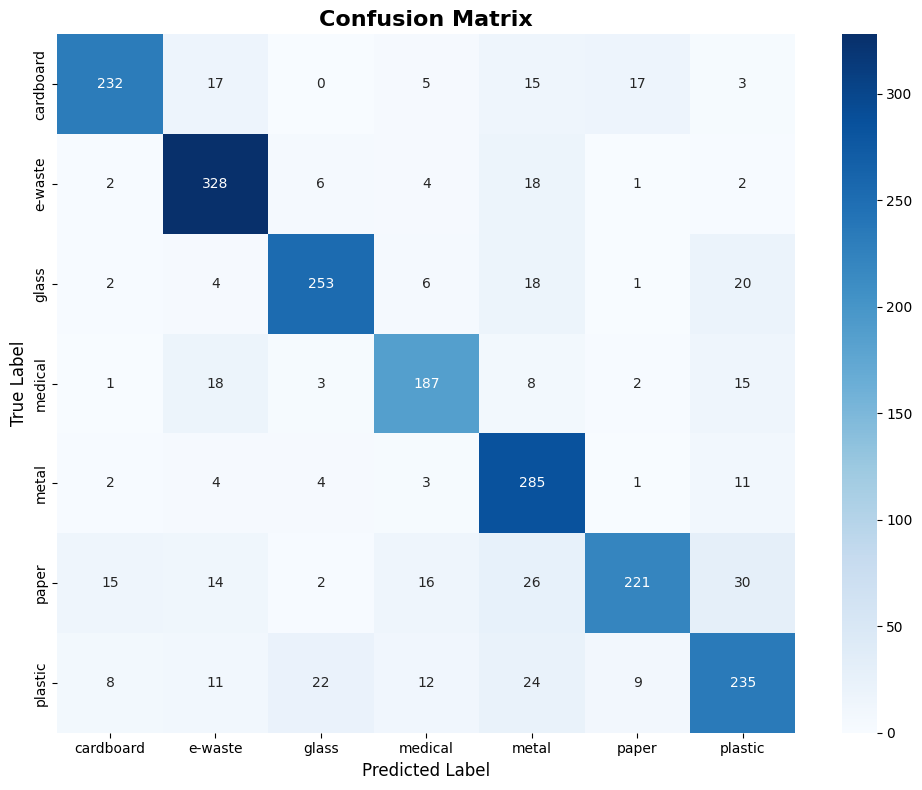

✓ Training curves saved to training_history.png


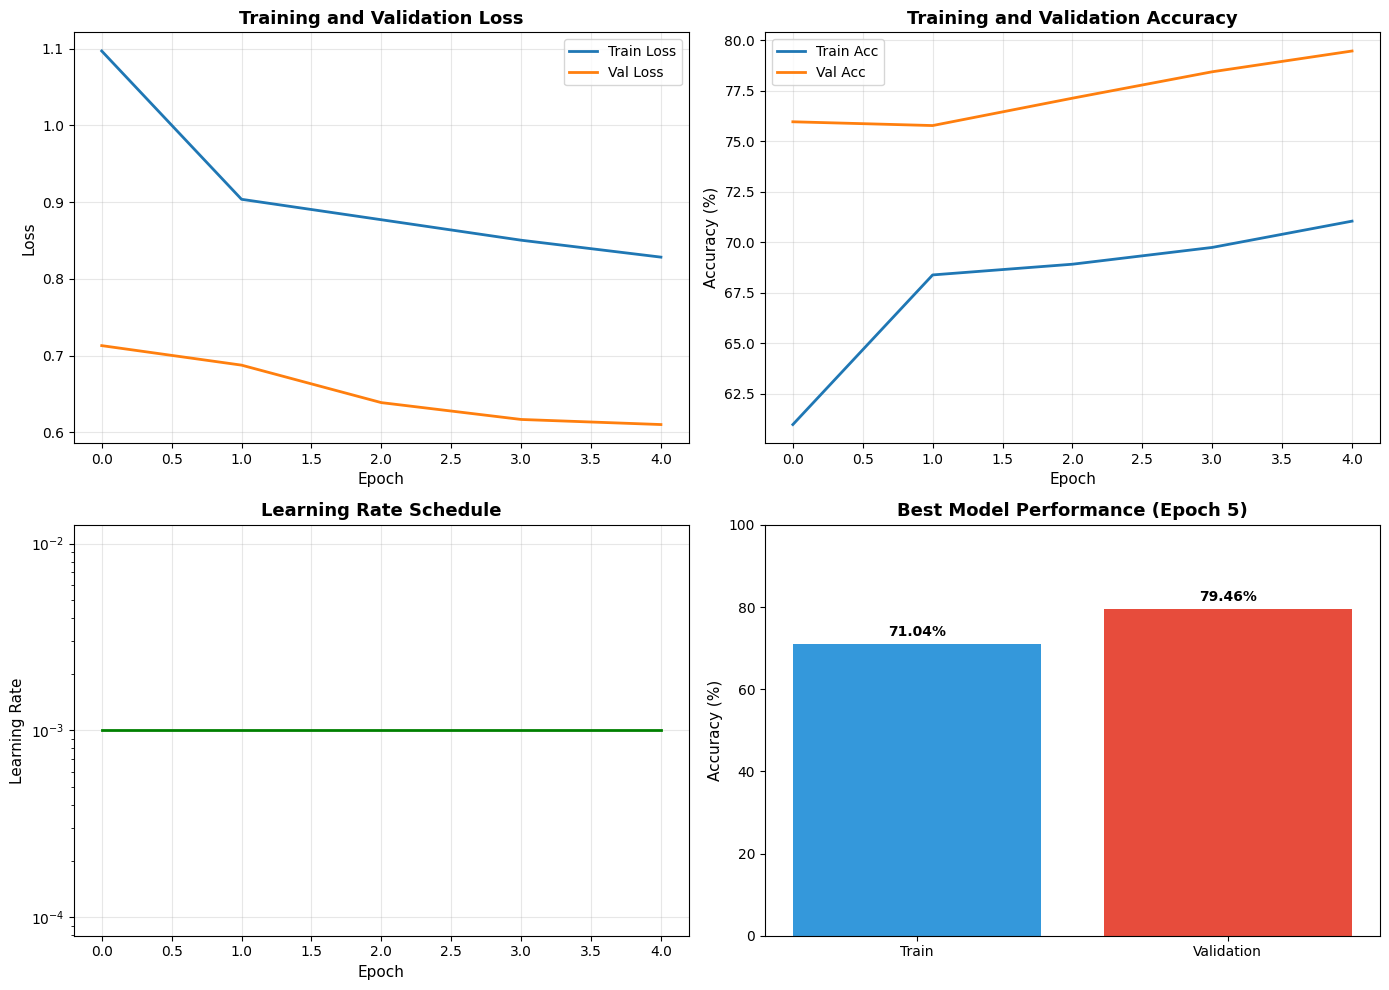

✓ Complete model saved to trashbox_resnet34_complete.pth
✓ Configuration saved to model_config.json

✓ TRAINING COMPLETE!
Best Validation Accuracy: 79.46%
Test Accuracy: 81.24%

Saved files:
  - trashbox_resnet34_best.pth
  - trashbox_resnet34_complete.pth
  - model_config.json
  - training_history.json
  - confusion_matrix.png
  - training_history.png


In [ ]:
"""
TrashBox Waste Classification using ResNet-34 Transfer Learning
Complete implementation with training and inference capabilities

SETUP INSTRUCTIONS FOR GOOGLE COLAB:
1. Upload this notebook to Colab
2. Runtime > Change runtime type > GPU (T4)
3. Run the cells in order
"""

# =============================================================================
# SECTION 1: SETUP AND INSTALLATIONS
# =============================================================================

# Install required packages
!pip install -q torch torchvision tqdm pillow matplotlib scikit-learn


# Verify GPU
import torch
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠ WARNING: GPU not available! Go to Runtime > Change runtime type > GPU")

# =============================================================================
# SECTION 2: IMPORTS
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}\n")

# =============================================================================
# SECTION 3: CONFIGURATION
# =============================================================================

class Config:
    # Dataset path (update if your folder structure is different)
    DATASET_PATH = '/content/TrashBox/TrashBox_train_set'

    # Output paths
    MODEL_SAVE_PATH = 'trashbox_resnet34_best.pth'
    MODEL_FULL_SAVE_PATH = 'trashbox_resnet34_complete.pth'
    CONFIG_SAVE_PATH = 'model_config.json'
    HISTORY_SAVE_PATH = 'training_history.json'

    # Classes (must match folder names exactly)
    CLASSES = ['cardboard', 'e-waste', 'glass', 'medical', 'metal', 'paper', 'plastic']
    NUM_CLASSES = len(CLASSES)

    # Training hyperparameters
    BATCH_SIZE = 32
    NUM_EPOCHS = 5
    INITIAL_LR = 0.001
    LR_DECAY = 0.1
    DECAY_EPOCHS = [30, 60, 90]

    # Image parameters
    IMG_SIZE = 224

    # Data split
    TRAIN_SPLIT = 0.7
    VAL_SPLIT = 0.15
    TEST_SPLIT = 0.15

    # Early stopping
    PATIENCE = 15  # Stop if no improvement for 15 epochs

    @classmethod
    def save_config(cls):
        """Save configuration to JSON"""
        config_dict = {
            'classes': cls.CLASSES,
            'num_classes': cls.NUM_CLASSES,
            'img_size': cls.IMG_SIZE,
            'batch_size': cls.BATCH_SIZE,
            'num_epochs': cls.NUM_EPOCHS,
            'model_architecture': 'ResNet-34',
            'saved_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(cls.CONFIG_SAVE_PATH, 'w') as f:
            json.dump(config_dict, f, indent=4)
        print(f"✓ Configuration saved to {cls.CONFIG_SAVE_PATH}")

config = Config()

# Verify dataset exists
if os.path.exists(config.DATASET_PATH):
    print(f"✓ Dataset found at: {config.DATASET_PATH}")
    print(f"✓ Classes: {config.CLASSES}")
else:
    print(f"✗ ERROR: Dataset not found at {config.DATASET_PATH}")
    print("Please update DATASET_PATH in Config class")

# =============================================================================
# SECTION 4: DATASET CLASS
# =============================================================================

class TrashBoxDataset(Dataset):
    """Custom dataset for TrashBox images"""

    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            # Return a black image if there's an error
            return torch.zeros((3, config.IMG_SIZE, config.IMG_SIZE)), self.labels[idx]

# =============================================================================
# SECTION 5: DATA LOADING
# =============================================================================

def load_dataset(dataset_path, classes):
    """Load all images and labels from dataset"""
    image_paths = []
    labels = []
    class_counts = {}

    print("\nLoading dataset...")
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)

        if not os.path.exists(class_path):
            print(f"⚠ Warning: {class_path} not found! Skipping...")
            continue

        count = 0
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_paths.append(os.path.join(class_path, img_name))
                labels.append(class_idx)
                count += 1

        class_counts[class_name] = count
        print(f"  {class_name:12s}: {count:5d} images")

    print(f"\n✓ Total images loaded: {len(image_paths)}")
    return image_paths, labels, class_counts

def get_transforms():
    """Define data augmentation and normalization"""

    # Training: with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Validation/Test: only normalization
    val_test_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_test_transform

def prepare_dataloaders():
    """Create train, validation, and test dataloaders"""

    # Load dataset
    image_paths, labels, class_counts = load_dataset(config.DATASET_PATH, config.CLASSES)

    # Split dataset (stratified to maintain class balance)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        image_paths, labels,
        test_size=(config.VAL_SPLIT + config.TEST_SPLIT),
        stratify=labels,
        random_state=42
    )

    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels,
        test_size=config.TEST_SPLIT/(config.VAL_SPLIT + config.TEST_SPLIT),
        stratify=temp_labels,
        random_state=42
    )

    print(f"\n✓ Data split:")
    print(f"  Training:   {len(train_paths):5d} images ({len(train_paths)/len(image_paths)*100:.1f}%)")
    print(f"  Validation: {len(val_paths):5d} images ({len(val_paths)/len(image_paths)*100:.1f}%)")
    print(f"  Testing:    {len(test_paths):5d} images ({len(test_paths)/len(image_paths)*100:.1f}%)")

    # Get transforms
    train_transform, val_test_transform = get_transforms()

    # Create datasets
    train_dataset = TrashBoxDataset(train_paths, train_labels, train_transform)
    val_dataset = TrashBoxDataset(val_paths, val_labels, val_test_transform)
    test_dataset = TrashBoxDataset(test_paths, test_labels, val_test_transform)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader, class_counts

# =============================================================================
# SECTION 6: MODEL ARCHITECTURE
# =============================================================================
class TrashClassifierResNet34(nn.Module):
    """ResNet-34 based trash classifier with custom head"""

    def __init__(self, num_classes=7):
        super(TrashClassifierResNet34, self).__init__()

        # Load pre-trained ResNet-34
        self.resnet = models.resnet34(pretrained=True)

        # Freeze base layers initially#This prevents the model from changing what it already learned
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Get number of features from last layer
        num_features = self.resnet.fc.in_features

        # Replace the original classifier with custom one
        self.resnet.fc = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.5),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        # Store reference to classifier for training phases
        self.classifier = self.resnet.fc

    def forward(self, x):
        return self.resnet(x)

    def unfreeze_base_layers(self):#Now the whole model can fine-tune itself specifically for trash
        """Unfreeze base ResNet layers for fine-tuning"""
        for param in self.resnet.parameters():
            param.requires_grad = True
        # Re-enable training for classifier
        for param in self.classifier.parameters():
            param.requires_grad = True
'''
class TrashClassifierResNet34(nn.Module):
    """ResNet-34 based trash classifier with custom head"""

    def __init__(self, num_classes=7):
        super(TrashClassifierResNet34, self).__init__()

        # Load pre-trained ResNet-34
        self.resnet = models.resnet34(pretrained=True)

        # Freeze base layers initially
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Get number of features from last layer
        num_features = self.resnet.fc.in_features

        # Remove original classifier
        self.resnet.fc = nn.Identity()

        # Custom classifier as per paper
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.5),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)
        return x

    def unfreeze_base_layers(self):
        """Unfreeze base ResNet layers for fine-tuning"""
        for param in self.resnet.parameters():
            param.requires_grad = True
'''
# =============================================================================
# SECTION 7: TRAINING FUNCTIONS
# =============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f"{running_loss/len(dataloader):.4f}",
            'acc': f"{100.*correct/total:.2f}%"
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f"{running_loss/len(dataloader):.4f}",
                'acc': f"{100.*correct/total:.2f}%"
            })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, num_epochs, device):
    """Complete training procedure"""

    criterion = nn.CrossEntropyLoss()
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr': []
    }

    best_val_acc = 0.0
    patience_counter = 0

    print("\n" + "="*70)
    print("PHASE 1: Training classifier only (frozen backbone)")
    print("="*70)

    # Phase 1: Train classifier only
    optimizer = optim.Adam(model.classifier.parameters(), lr=config.INITIAL_LR)
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=config.DECAY_EPOCHS,
        gamma=config.LR_DECAY
    )

    for epoch in range(min(30, num_epochs)):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch [{epoch+1}/{num_epochs}] | LR: {current_lr:.6f}")

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        scheduler.step()

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        # Print results
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%", end="")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), config.MODEL_SAVE_PATH)
            print(" ← ✓ Best model saved!")
            patience_counter = 0
        else:
            print()
            patience_counter += 1

        # Early stopping
        if patience_counter >= config.PATIENCE:
            print(f"\n⚠ Early stopping triggered! No improvement for {config.PATIENCE} epochs.")
            break

    # Phase 2: Fine-tune entire network
    if num_epochs > 30 and epoch >= 29:
        print("\n" + "="*70)
        print("PHASE 2: Fine-tuning entire network (unfrozen backbone)")
        print("="*70)

        model.unfreeze_base_layers()
        optimizer = optim.Adam(model.parameters(), lr=config.INITIAL_LR * 0.1)
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=[i-30 for i in config.DECAY_EPOCHS if i > 30],
            gamma=config.LR_DECAY
        )

        patience_counter = 0

        for epoch in range(30, num_epochs):
            current_lr = optimizer.param_groups[0]['lr']
            print(f"\nEpoch [{epoch+1}/{num_epochs}] | LR: {current_lr:.6f}")

            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc = validate(model, val_loader, criterion, device)

            scheduler.step()

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['lr'].append(current_lr)

            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%", end="")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), config.MODEL_SAVE_PATH)
                print(" ← ✓ Best model saved!")
                patience_counter = 0
            else:
                print()
                patience_counter += 1

            if patience_counter >= config.PATIENCE:
                print(f"\n⚠ Early stopping triggered! No improvement for {config.PATIENCE} epochs.")
                break

    # Save training history
    with open(config.HISTORY_SAVE_PATH, 'w') as f:
        json.dump(history, f, indent=4)
    print(f"\n✓ Training history saved to {config.HISTORY_SAVE_PATH}")

    return history, best_val_acc

# =============================================================================
# SECTION 8: EVALUATION FUNCTIONS
# =============================================================================

def test_model(model, test_loader, device, class_names):
    """Comprehensive model evaluation"""

    print("\n" + "="*70)
    print("TESTING MODEL")
    print("="*70)

    model.eval()
    all_predictions = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Overall accuracy
    test_acc = 100. * correct / total
    print(f"\n✓ Overall Test Accuracy: {test_acc:.2f}%")

    # Classification report
    print("\n" + "-"*70)
    print("CLASSIFICATION REPORT")
    print("-"*70)
    print(classification_report(
        all_labels,
        all_predictions,
        target_names=class_names,
        digits=4
    ))

    # Per-class accuracy
    print("\n" + "-"*70)
    print("PER-CLASS ACCURACY")
    print("-"*70)
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)

    for label, pred in zip(all_labels, all_predictions):
        class_total[label] += 1
        if label == pred:
            class_correct[label] += 1

    for i, class_name in enumerate(class_names):
        if class_total[i] > 0:
            acc = 100. * class_correct[i] / class_total[i]
            print(f"{class_name:12s}: {acc:6.2f}% ({class_correct[i]}/{class_total[i]})")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plot_confusion_matrix(cm, class_names)

    return test_acc, all_predictions, all_labels

def plot_confusion_matrix(cm, class_names):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("\n✓ Confusion matrix saved to confusion_matrix.png")
    plt.show()

def plot_training_history(history):
    """Plot training curves"""

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Loss plot
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Loss', fontsize=11)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[0, 1].plot(history['train_acc'], label='Train Acc', linewidth=2)
    axes[0, 1].plot(history['val_acc'], label='Val Acc', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Accuracy (%)', fontsize=11)
    axes[0, 1].set_title('Training and Validation Accuracy', fontsize=13, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate plot
    axes[1, 0].plot(history['lr'], linewidth=2, color='green')
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Learning Rate', fontsize=11)
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=13, fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    # Accuracy comparison
    best_val_idx = np.argmax(history['val_acc'])
    axes[1, 1].bar(['Train', 'Validation'],
                   [history['train_acc'][best_val_idx], history['val_acc'][best_val_idx]],
                   color=['#3498db', '#e74c3c'])
    axes[1, 1].set_ylabel('Accuracy (%)', fontsize=11)
    axes[1, 1].set_title(f'Best Model Performance (Epoch {best_val_idx+1})',
                         fontsize=13, fontweight='bold')
    axes[1, 1].set_ylim([0, 100])
    for i, v in enumerate([history['train_acc'][best_val_idx], history['val_acc'][best_val_idx]]):
        axes[1, 1].text(i, v + 2, f'{v:.2f}%', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    print("✓ Training curves saved to training_history.png")
    plt.show()

# =============================================================================
# SECTION 9: MODEL SAVING AND LOADING
# =============================================================================

def save_complete_model(model, optimizer, epoch, best_val_acc, class_names):
    """Save complete model with all metadata for inference"""

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_acc': best_val_acc,
        'class_names': class_names,
        'num_classes': len(class_names),
        'img_size': config.IMG_SIZE,
        'model_architecture': 'ResNet-34',
        'saved_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }

    torch.save(checkpoint, config.MODEL_FULL_SAVE_PATH)
    print(f"✓ Complete model saved to {config.MODEL_FULL_SAVE_PATH}")

def load_model_for_inference(model_path=None):
    """Load trained model for inference"""

    if model_path is None:
        model_path = config.MODEL_FULL_SAVE_PATH

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Create model
    num_classes = checkpoint['num_classes']
    model = TrashClassifierResNet34(num_classes=num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Get metadata
    class_names = checkpoint['class_names']
    img_size = checkpoint['img_size']

    print(f"✓ Model loaded from {model_path}")
    print(f"  Architecture: {checkpoint['model_architecture']}")
    print(f"  Classes: {class_names}")
    print(f"  Best validation accuracy: {checkpoint['best_val_acc']:.2f}%")
    print(f"  Saved on: {checkpoint['saved_date']}")

    return model, class_names, img_size

# =============================================================================
# SECTION 10: INFERENCE FUNCTIONS
# =============================================================================

def predict_single_image(image_path, model, class_names, img_size=224, show_image=True):
    """Predict class for a single image"""

    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = probabilities.max(1)

    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item() * 100

    # Show results
    if show_image:
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Predicted: {predicted_class} ({confidence_score:.2f}% confidence)',
                 fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    # Print all class probabilities
    print(f"\n{'Class':<15} {'Probability':<12} {'Bar'}")
    print("-" * 50)
    for i, class_name in enumerate(class_names):
        prob = probabilities[0][i].item() * 100
        bar = '█' * int(prob / 2)
        print(f"{class_name:<15} {prob:>6.2f}%     {bar}")

    return predicted_class, confidence_score

def predict_batch_images(image_folder, model, class_names, img_size=224, max_display=10):
    """Predict classes for multiple images in a folder"""

    image_files = [f for f in os.listdir(image_folder)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    if not image_files:
        print(f"No images found in {image_folder}")
        return

    print(f"\n✓ Found {len(image_files)} images")

    results = []
    for img_file in tqdm(image_files[:max_display], desc="Predicting"):
        img_path = os.path.join(image_folder, img_file)
        predicted_class, confidence = predict_single_image(
            img_path, model, class_names, img_size, show_image=False
        )
        results.append({
            'filename': img_file,
            'predicted_class': predicted_class,
            'confidence': confidence
        })

    # Display results
    print(f"\n{'Filename':<30} {'Predicted Class':<15} {'Confidence'}")
    print("-" * 65)
    for result in results:
        print(f"{result['filename']:<30} {result['predicted_class']:<15} {result['confidence']:>6.2f}%")

    return results
# =============================================================================
# SECTION 11: MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("TRASHBOX WASTE CLASSIFICATION - TRAINING PIPELINE")
    print("="*70)

    # Step 1: Prepare data
    train_loader, val_loader, test_loader, class_counts = prepare_dataloaders()

    # Step 2: Create model
    print("\n✓ Creating ResNet-34 model...")
    model = TrashClassifierResNet34(num_classes=config.NUM_CLASSES)
    model = model.to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✓ Total parameters: {total_params:,}")
    print(f"✓ Trainable parameters: {trainable_params:,}")

    # Step 3: Train model
    history, best_val_acc = train_model(
        model, train_loader, val_loader,
        config.NUM_EPOCHS, device
    )

    # Step 4: Load best model and test
    print("\n✓ Loading best model for testing...")
    model.load_state_dict(torch.load(config.MODEL_SAVE_PATH))

    test_acc, predictions, labels = test_model(
        model, test_loader, device, config.CLASSES
    )

    # Step 5: Plot results
    plot_training_history(history)

    # Step 6: Save complete model
    optimizer = optim.Adam(model.parameters())  # Create optimizer for saving
    save_complete_model(model, optimizer, config.NUM_EPOCHS,
                       best_val_acc, config.CLASSES)

    # Step 7: Save configuration
    config.save_config()

    print("\n" + "="*70)
    print("✓ TRAINING COMPLETE!")
    print("="*70)
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"\nSaved files:")
    print(f"  - {config.MODEL_SAVE_PATH}")
    print(f"  - {config.MODEL_FULL_SAVE_PATH}")
    print(f"  - {config.CONFIG_SAVE_PATH}")
    print(f"  - {config.HISTORY_SAVE_PATH}")
    print(f"  - confusion_matrix.png")
    print(f"  - training_history.png")
# =============================================================================

In [ ]:
# Remove corrupted images
corrupted_files = [
    '/content/TrashBox/TrashBox_train_set/paper/paper 2273.jpg',
   ]

for file_path in corrupted_files:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"✓ Removed: {file_path}")

✓ Removed: /content/TrashBox/TrashBox_train_set/paper/paper 2273.jpg
